##GNN and Traditional algorithms for Movielens



In [1]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
from networkx.algorithms import bipartite
import torch
import torch.nn as nn
import torch.nn.functional as F

In [2]:

data = pd.read_csv('movielens-20m/rating.csv')
movies_df = pd.read_csv("movielens-20m/movie.csv")
tags_df = pd.read_csv("movielens-20m/tag.csv")
genome_scores_raw = pd.read_csv("movielens-20m/genome_scores.csv")
print(len(data))
def load_data(data, size):
    data = data.iloc[:size]
    genome_scores = genome_scores_raw[genome_scores_raw['movieId'].isin(data['movieId'].unique())]
    train_data = data.copy()
    test_data = pd.DataFrame()

    movie_num_user_rated_counts = train_data['movieId'].value_counts()
    popular_movies = movie_num_user_rated_counts[movie_num_user_rated_counts >= 10].index.tolist()
    train_data = train_data[train_data['movieId'].isin(popular_movies)]

    test_indices = []
    for user_id in train_data['userId'].unique():
        user_ratings_indices = train_data[train_data['userId'] == user_id].index
        if len(user_ratings_indices) > 1:
            test_indices.append(np.random.choice(user_ratings_indices))

    test_data = train_data.loc[test_indices]
    train_data = train_data.drop(test_indices)

    return train_data, test_data, genome_scores

20000263


##Visual

In [3]:
import networkx as nx
from networkx.algorithms import bipartite

# 1. Create a new graph
def makegraph(train_data):
    ratings_df = train_data

    G = nx.Graph()

    # 2. Bulk add user nodes
    unique_users = ratings_df['userId'].unique()
    G.add_nodes_from(unique_users, bipartite=0)

    # 3. Bulk add movie nodes
    movie_nodes = [('m_' + str(row['movieId']), {'bipartite': 1, 'title': row['title'], 'genres': row['genres'].split('|')}) for _, row in movies_df.iterrows()]
    G.add_nodes_from(movie_nodes)

    # 4. Bulk add edges
    edges = [(row['userId'], 'm_' + str(row['movieId']), {'rating': row['rating'], 'timestamp': row['timestamp']}) for _, row in ratings_df.iterrows()]
    G.add_edges_from(edges)

    # 5. Group tags by movie and add them to the graph
    grouped_tags = tags_df.groupby('movieId')
    for movieId, group in grouped_tags:
        movie_node = 'm_' + str(movieId)
        G.nodes[movie_node]['tags'] = group[['tag', 'timestamp', 'userId']].to_dict('records')

    # 6. Ensure the graph is bipartite
    assert bipartite.is_bipartite(G)
    return G


In [4]:
def prepare_data(train_data, genome_scores_data):
    # Loading the data
    ratings = train_data
    genome_scores = genome_scores_data
    
    # Adjust relevance values in genome_scores such that the median becomes 0
    relevance_median = genome_scores['relevance'].median()
    genome_scores['relevance'] -= relevance_median

    # Scaling the values of relevance
    max_zero_centered_relevance = genome_scores['relevance'].max()
    min_zero_centered_relevance = genome_scores['relevance'].min()
    scaler_positive_values = 0.5 / max_zero_centered_relevance
    scaler_negative_values = -0.5 / min_zero_centered_relevance

    genome_scores['relevance'] = np.where(
        genome_scores['relevance'] > 0,
        genome_scores['relevance'] * scaler_positive_values,
        genome_scores['relevance'] * scaler_negative_values
    ) + 0.5

    # Make relevance and label values be mapped to closest element in bins_values
    bins_values = np.array([0, 0.125, 0.25, 0.375, 0.5, 0.625, 0.75, 0.875, 1])
    genome_scores['relevance'] = genome_scores['relevance'].apply(lambda x: bins_values[np.abs(bins_values - x).argmin()])

    # Converting ratings to be from 0 to 1 and mapping them to closest element in bins_values
    ratings['rating'] = (ratings['rating'] - 1) / 4
    ratings['rating'] = ratings['rating'].apply(lambda x: bins_values[np.abs(bins_values - x).argmin()])
    
    return ratings, genome_scores, bins_values

def predict_rating_for_movie(user_id, movie_id, ratings, genome_scores, bins_values):
    user_ratings = ratings[ratings['userId'] == user_id]
    movies_rated_by_user = user_ratings['movieId'].tolist()
    genome_scores_movies_rated_by_user = genome_scores[genome_scores['movieId'].isin(movies_rated_by_user)]
    
    
    # Getting the probabilities for all labels
    probability_label = {}
    for label_value in bins_values:
        probability_label[label_value] = compute_movie_output(movie_id, user_id, user_ratings, genome_scores_movies_rated_by_user, genome_scores, label_value)
    
    most_probable_label = max(probability_label, key=probability_label.get)
    return (most_probable_label * 4) + 1
def get_probability(user_ratings, genome_scores_user, tag_id, relevance, label):
    """Function to calculate the probability for a tagId based on user ratings."""
   
    # Filtered genome_scores_user with same relevance for the given tagId
    relevant_movies_rated_by_user = genome_scores_user[(genome_scores_user['tagId'] == tag_id) & (genome_scores_user['relevance'] == relevance)]
       
    if relevant_movies_rated_by_user.empty:
        return 1  # If the user hasn't rated any movies with that relevance and tagId, we'll consider a default probability of 1.
   
    # Count the number of those movies (in relevant_movies_rated_by_user) rated with a value of label
    num_rated_label = user_ratings[user_ratings['movieId'].isin(relevant_movies_rated_by_user['movieId']) & (user_ratings['rating'] == label)].shape[0]
   
    return (num_rated_label / relevant_movies_rated_by_user.shape[0]) + 1

def compute_movie_output(movie_id, user_id, user_ratings, genome_scores_user, genome_scores, label):
    """Function to compute output for a movie based on user's ratings."""
   
    # Get the tag relevance scores for the movie
    movie_relevance_scores = genome_scores[genome_scores['movieId'] == movie_id]
   
    # Calculate the probability for each tagId. It iterates through every row in movie_relevance_scores, passing as parameters the tagId (row['tagId']) and relevance (row['relevance'])
    probabilities = [get_probability(user_ratings, genome_scores_user, row['tagId'], row['relevance'], label) for _, row in movie_relevance_scores.iterrows()]
   
    # Calculate output by multiplying all the probabilities
    output = 1
    for prob in probabilities:
        output *= prob
   
    return output

In [5]:
def cosine_similarity_matrix(tr_data):
    
    # Create a user-movie matrix with NaN for unrated movies
    df_user_movie = tr_data.pivot(index='userId', columns='movieId', values='rating')

    # Put 0 instead of NaNs
    df_user_movie = df_user_movie.fillna(0)
    
    num_users = len(df_user_movie)

    # Create an empty DataFrame with user IDs as row and column indices - cosine similatity matrix
    user_ids = range(1, num_users + 1)
    user_similarity_df = pd.DataFrame(index=user_ids, columns=user_ids)
    
    # Fill incosine similarity matrix
    for i in range(num_users):
        for j in range(num_users):
            user_similarity_df.at[i + 1, j + 1] = cosine_similarity1(df_user_movie.iloc[i], df_user_movie.iloc[j])
            
    # Set the user similarity to themself to 0
    # Set values to 0 where i == j

    for i in range(user_similarity_df.shape[0]):
        user_similarity_df.iat[i, i] = 0
        
    return user_similarity_df
            
def cosine_similarity1(vector1, vector2):
    dot_product = np.dot(vector1, vector2)
    norm_vector1 = np.linalg.norm(vector1)
    norm_vector2 = np.linalg.norm(vector2)
    similarity = dot_product / (norm_vector1 * norm_vector2)
    return similarity

def cosine_based_prediction(cosine_similarity_df, user_to_predict, movie_to_rate, train_data):
    
    row_user_to_predict = cosine_similarity_df.index.get_loc(user_to_predict)
    
    # Steps:
    # 1. Make user_similarity_df from a train set 
    # 2. For a user find the closet users who have rated the movie
    # 3. Take the average of the rating and return it 
    # 2. For a user find the closet users who have rated the movie
    sorted_similarities = cosine_similarity_df.iloc[row_user_to_predict].sort_values(ascending=False)
    # Loop through the sorted users to find a user who has rated the movie
    for user_id, similarity in sorted_similarities.items():
        # Filter the DataFrame to get ratings by the current user
        filtered_df = train_data[train_data['userId'] == user_id]
        
        # Check if this user has rated the movie
        if movie_to_rate in filtered_df['movieId'].values:
            return filtered_df[filtered_df['movieId'] == movie_to_rate]['rating'].mean()
    
    return 3.53 #Mean

In [6]:
def predict_rating(G, user, movie):
    neighbors = list(G.neighbors(movie))
    if not neighbors:
        return np.mean([attr['rating'] for _, _, attr in G.edges(data=True) if 'rating' in attr])

    sim_weights = []
    user_ratings = []
    for neighbor in neighbors:
        # Jaccard similarity as an example, but can be changed
        common_movies = list(nx.common_neighbors(G, user, neighbor))
        sim = len(common_movies) / (G.degree(user) + G.degree(neighbor) - len(common_movies))
        rating = G[neighbor][movie]['rating']
        
        sim_weights.append(sim)
        user_ratings.append(rating)
    
    return np.dot(user_ratings, sim_weights) / sum(sim_weights)


In [ ]:
def personalized_pagerank_recommendations(G, user, alpha=0.85):
    """Generate recommendations for a user using Personalized PageRank."""
    personalization = {node: 0 for node in G.nodes()}
    for neighbor in G.neighbors(user):
        personalization[neighbor] = G[user][neighbor]['rating']
    
    ppr = nx.pagerank(G, alpha=alpha, personalization=personalization)
    
    movies = [node for node in ppr.keys() if G.nodes[node]['bipartite'] == 1]
    sorted_movies = sorted(movies, key=lambda x: ppr[x], reverse=True)
    
    return sorted_movies


In [ ]:
import seaborn as sns

# Compute KDE of train ratings


def predict_rating_ppr_kde(G, user, movie,rating_kde,train_data):
    sorted_movies = personalized_pagerank_recommendations(G, user)
    
    if not sorted_movies:
        return train_data['rating'].mean()
    
    if movie in sorted_movies:
        rank = sorted_movies.index(movie)
    else:
        rank = len(sorted_movies)
    
    # Calculate rank percentile
    rank_percentile = rank / len(sorted_movies)
    
    # Map rank percentile to KDE
    y = np.interp(rank_percentile, rating_kde[1], rating_kde[0])
    return y




In [ ]:
from node2vec import Node2Vec
from sklearn.metrics.pairwise import cosine_similarity
def load_node2vec(G):
    node2vec = Node2Vec(G, dimensions=64, walk_length=30, num_walks=200, workers=52)  
    model = node2vec.fit(window=10, min_count=1)
    return model


def predict_rating_node2vec(model, user, movie):
    user_vector = model.wv[str(user)]
    movie_vector = model.wv[str(movie)]

    similarity = cosine_similarity([user_vector], [movie_vector])[0][0]

    predicted_rating = (4 * ((similarity+1)/2)) + 1
    return predicted_rating


/home/raaf/Pythonprojects/Recommender_systems/venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [7]:

from scipy.sparse import csr_matrix
from sklearn.neighbors import NearestNeighbors
def create_pivot_table(data,defaultval):
    #data = pd.merge(movies_df,ratings_df)
    return data.pivot_table(index=["movieId"], columns=["userId"], values="rating").fillna(defaultval)

def create_knn(pivot_table):
    new_knn = NearestNeighbors(metric = 'cosine', algorithm = 'brute')
    pivot_matrix = csr_matrix(pivot_table.values) #Required for knn
    new_knn.fit(pivot_matrix)
    return new_knn

#Takes
def predict_user_rating_rafael(userId, movieId, pivot_table, k, knn_model):
    #Get movie's nearest neighbors
    movieId_index = pivot_table.index.get_loc(movieId)
    
    #print(movieId_index)
    #print(pivot_table.iloc[movieId_index,:])
    p_distances, p_indices  = knn_model.kneighbors(pivot_table.iloc[movieId_index,:].values.reshape(1,-1), n_neighbors = k+1)
    p_indices = p_indices[0][1:]
    
    
    #Get users ratings for those movies
    ratings = []
    
    for index in p_indices:
        #print(pivot_table.iloc[index, userId])
        userId_index = pivot_table.columns.get_loc(userId)
        ratings.append(pivot_table.iloc[index, userId_index])
        
        
    #Average their ratings to find their predicted rating for the target movie
    average = sum(ratings)/len(ratings)
    return average

def predict_user_rating_rafael2(userId, movieId, pivot_table, k, knn_model):
    movieId_index = pivot_table.index.get_loc(movieId)
    p_distances, p_indices = knn_model.kneighbors(pivot_table.iloc[movieId_index, :].values.reshape(1, -1), n_neighbors=k + 1)
    p_indices = p_indices[0][1:]

    ratings = []
    for index in p_indices:
        userId_index = pivot_table.columns.get_loc(userId)
        rating = pivot_table.iloc[index, userId_index]
        if rating != -1:  # Only consider movies that the user has rated
            ratings.append(rating)

    if len(ratings) == 0:  # If the user hasn't rated any of the neighbors
        return 3.53  # or return a default value or handle it in some other way

    average = sum(ratings) / len(ratings)
    return average
#Steps:
#Initialize pivot_table -> Initialize Knn -> Use prediction Method



In [ ]:
test_predictions = []
actual_ratings = []
test_predictions_knn = []
test_predictions_knn2 = []
#test_predictions_node2vec = []
test_predictions_Sonya = []
test_predictions_GNN = []

import concurrent.futures
def calculate_rmse_for_data_size(data_size, k):
    train_data, test_data = load_data(data, data_size)
    print("Finished loading Data")
    cosine_matrix = cosine_similarity_matrix(train_data)
    print("Finished cosine matrix")
    #rating_kde = sns.kdeplot(train_data['rating'], cumulative=True, bw_adjust=0.5).get_lines()[0].get_data()
    G = makegraph(train_data)
    pivot = create_pivot_table(train_data.drop('timestamp', axis=1),3.53)
    print("Finished pivot table")
    pivot2 = create_pivot_table(train_data.drop('timestamp', axis=1),-1)
    print("Finished pivot table2")
    knn = create_knn(pivot)
    print("Finished knn")
    knn2 = create_knn(pivot2)
    print("Finished knn1")

    def process_row(row):
        movie = 'm_' + str(row['movieId'])
        results = {}
        if G.has_node(movie):
            results['actual_ratings'] = row['rating']
            results['test_predictions'] = predict_rating(G, row['userId'], movie)
            results['test_predictions_knn'] = predict_user_rating_rafael(row['userId'],row['movieId'],pivot,k,knn)
            results['test_predictions_knn2'] = predict_user_rating_rafael2(row['userId'],row['movieId'],pivot2,k,knn2)
            #results['test_predictions_node2vec'] = predict_rating_node2vec(G_train, row['userId'], row['movieId'])
            results['test_predictions_Sonya'] = cosine_based_prediction(cosine_matrix,row['userId'],row['movieId'],train_data)
        return results

    actual_ratings = []
    test_predictions = []
    test_predictions_knn = []
    test_predictions_knn2 = []
    #test_predictions_node2vec = []
    test_predictions_Sonya = []

    with concurrent.futures.ThreadPoolExecutor() as executor:
        futures = [executor.submit(process_row, row) for _, row in test_data.iterrows()]
        for future in concurrent.futures.as_completed(futures):
            results = future.result()
            if results:
                actual_ratings.append(results['actual_ratings'])
                test_predictions.append(results['test_predictions'])
                test_predictions_knn.append(results['test_predictions_knn'])
                test_predictions_knn2.append(results['test_predictions_knn2'])
                #test_predictions_node2vec.append(results['test_predictions_node2vec'])
                test_predictions_Sonya.append(results['test_predictions_Sonya'])


    # Calculate RMSE for PPR
    rmse_knn = np.sqrt(np.mean((np.array(test_predictions_knn) - np.array(actual_ratings)) ** 2)) 
    rmse_knn2 = np.sqrt(np.mean((np.array(test_predictions_knn2) - np.array(actual_ratings)) ** 2)) 
    # Calculate RMSE
    default = np.sqrt(np.mean((3.53 - np.array(actual_ratings)) ** 2))
    #rmse = np.sqrt(np.mean((np.array(test_predictions) - np.array(actual_ratings)) ** 2)) 
    #rmse_node2vec = np.sqrt(np.mean((np.array(test_predictions_node2vec) - np.array(actual_ratings)) ** 2))
    rmse_sonya = np.sqrt(np.mean((np.array(test_predictions_Sonya) - np.array(actual_ratings)) ** 2))

    return {
        "K": k,
        "default_rmse": default,
        #"jaccard_rmse": rmse,
        "knn_rmse": rmse_knn,
        "knn2_rmse": rmse_knn2,
        "sonya_rmse": rmse_sonya
    }


In [8]:
test_predictions = []
actual_ratings = []
test_predictions_knn = []
test_predictions_knn2 = []
#test_predictions_node2vec = []
test_predictions_Sonya = []
test_predictions_GNN = []

train_data, test_data, genome_scores = load_data(data, 10**6)
print("Finished loading Data")
cosine_matrix = cosine_similarity_matrix(train_data)
print("Finished cosine matrix")
#rating_kde = sns.kdeplot(train_data['rating'], cumulative=True, bw_adjust=0.5).get_lines()[0].get_data()
G = makegraph(train_data)
print("Finished graph")
#nodemodel = load_node2vec(G)
#print("Finished node2vec")
pivot = create_pivot_table(train_data.drop('timestamp', axis=1),3.53)
print("Finished pivot table")
pivot2 = create_pivot_table(train_data.drop('timestamp', axis=1),-1)
print("Finished pivot table2")
knn = create_knn(pivot)
print("Finished knn")
knn2 = create_knn(pivot2)
print("Finished knn1")
ratings, genome_scores, bins_values = prepare_data(train_data, genome_scores)
print("Finished genome")





Finished loading Data
Finished cosine matrix
Finished graph
Finished pivot table
Finished pivot table2
Finished knn
Finished knn1


/tmp/ipykernel_4635/1956417043.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  genome_scores['relevance'] -= relevance_median
/tmp/ipykernel_4635/1956417043.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  genome_scores['relevance'] = np.where(
/tmp/ipykernel_4635/1956417043.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-d

Finished genome


In [9]:
import concurrent.futures
import dill
from functools import partial
concurrent.futures.process._dill = dill
def process_row(row, G, pivot, k, knn, pivot2, knn2, cosine_matrix, train_data, ratings, genome_scores, bins_values):
    movie = 'm_' + str(row['movieId'])
    results = {}
    try:
        if G.has_node(movie):
            results['actual_ratings'] = row['rating']
            results['test_predictions'] = predict_rating(G, row['userId'], movie)
            results['test_predictions_knn'] = predict_user_rating_rafael(row['userId'],row['movieId'],pivot,k,knn)
            results['test_predictions_knn2'] = predict_user_rating_rafael2(row['userId'],row['movieId'],pivot2,k,knn2)
            #results['test_predictions_node2vec'] = predict_rating_node2vec(nodemodel, row['userId'], movie)
            results['test_predictions_Sonya'] = cosine_based_prediction(cosine_matrix,row['userId'],row['movieId'],train_data)
            results['test_predictions_bayes'] = predict_rating_for_movie(row['userId'], row['movieId'], ratings, genome_scores, bins_values)
    except KeyError:
        print("missing movie")
    return results

def calculate_rmse_for_data_size(data_size, k, knn, knn2):
    # Convert DataFrame to list of dictionaries for faster iteration
    test_data_list = test_data.to_dict('records')

    # Use a partial function to pass additional arguments to process_row
    process_func = partial(process_row, G=G, pivot=pivot, k=k, knn=knn, pivot2=pivot2, knn2=knn2, cosine_matrix=cosine_matrix, train_data=train_data, ratings=ratings, genome_scores=genome_scores, bins_values=bins_values)

    with concurrent.futures.ProcessPoolExecutor() as executor:
        results_list = list(executor.map(process_func, test_data_list))

    # Extract results
    actual_ratings = [res['actual_ratings'] for res in results_list]
    test_predictions = [res['test_predictions'] for res in results_list]
    test_predictions_knn = [res['test_predictions_knn'] for res in results_list]
    test_predictions_knn2 = [res['test_predictions_knn2'] for res in results_list]
    #test_predictions_node2vec = [res['test_predictions_node2vec'] for res in results_list]
    test_predictions_Sonya = [res['test_predictions_Sonya'] for res in results_list]
    test_predictions_bayes = [res['test_predictions_bayes'] for res in results_list]

   
    knn = np.array(test_predictions_knn) - np.array(actual_ratings)
    knn2 = np.array(test_predictions_knn2) - np.array(actual_ratings)
    
    default = 3.53 - np.array(actual_ratings)
    jaccards = np.array(test_predictions) - np.array(actual_ratings)
    #node2vec = np.array(test_predictions_node2vec) - np.array(actual_ratings)
    cosine_similarity = np.array(test_predictions_Sonya) - np.array(actual_ratings)
    bayes = np.array(test_predictions_bayes) - np.array(actual_ratings)
    
    rmse_knn = np.sqrt(np.mean(knn**2))
    rmse_knn2 = np.sqrt(np.mean(knn2**2))
    rmse_default = np.sqrt(np.mean(default**2))
    rmse_jaccards = np.sqrt(np.mean(jaccards**2))
    #rmse_node2vec = np.sqrt(np.mean(node2vec**2))
    rmse_cosine_similarity = np.sqrt(np.mean(cosine_similarity**2))
    rmse_bayes = np.sqrt(np.mean(bayes**2))

    # Collect RMSE values and method names
    methods = ['KNN', 'KNN2', 'Default', 'Jaccards', 'Node2Vec', 'Cosine Similarity', 'Bayes']
    rmse_values = [rmse_knn, rmse_knn2, rmse_default, rmse_jaccards, rmse_cosine_similarity, rmse_bayes]

    # Plotting
    import matplotlib.pyplot as plt

    # Assuming you want standard deviation as error bars
    std_devs = [np.std(knn), np.std(knn2), np.std(default), np.std(jaccards), np.std(cosine_similarity), np.std(bayes)]

    plt.bar(methods, rmse_values, yerr=std_devs, capsize=10)
    plt.ylabel('RMSE')
    plt.title('RMSE of Different Methods with Error Bars')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()
    df = pd.DataFrame({
        'actual_ratings': actual_ratings,
        'knn_diff': knn,
        'knn2_diff': knn2,
        'default_diff': default,
        'jaccards_diff': jaccards,
        'cosine_similarity_diff': cosine_similarity,
        'bayes_diff': bayes
    })

    # Save the DataFrame to a CSV file
    df.to_csv('raw_data_differences2.csv', index=False)

In [ ]:
log_points = np.logspace(np.log10(1), np.log10(500), 15)
ks = [int(point) for point in log_points] # Adjust the step size as needed
data_size = 10**6
results = []
for k in ks:
    print(f"Processing data size: {data_size}")
    result = calculate_rmse_for_data_size(data_size,k)
    results.append(result)

# Convert results to DataFrame and save to CSV
df = pd.DataFrame(results)
df.to_csv("rmse_results.csv", index=False)

Processing data size: 1000000
Processing data size: 1000000
Processing data size: 1000000
Processing data size: 1000000
Processing data size: 1000000
Processing data size: 1000000
Processing data size: 1000000
Processing data size: 1000000
Processing data size: 1000000
Processing data size: 1000000
Processing data size: 1000000
Processing data size: 1000000
Processing data size: 1000000
Processing data size: 1000000
Processing data size: 1000000


In [10]:
calculate_rmse_for_data_size(10**5,50,knn,knn2)

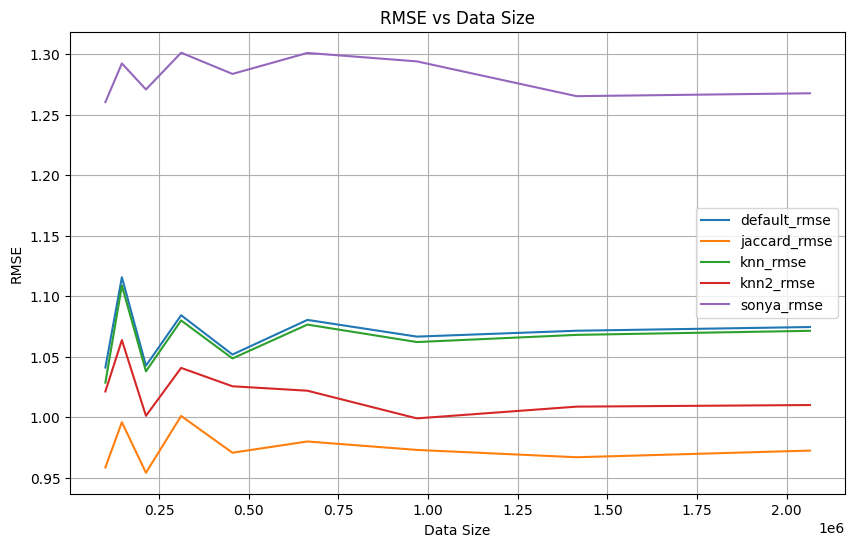

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

data = [
    {'data_size': 100000, 'default_rmse': 1.0409231876661615, 'jaccard_rmse': 0.958323759459673, 'knn_rmse': 1.028443732732137, 'knn2_rmse': 1.0211321621439473, 'sonya_rmse': 1.2602853202029642},
    {'data_size': 146002, 'default_rmse': 1.115569587976464, 'jaccard_rmse': 0.9957294301603007, 'knn_rmse': 1.1086767026049011, 'knn2_rmse': 1.0635798314991034, 'sonya_rmse': 1.2923124628092757},
    {'data_size': 213166, 'default_rmse': 1.042443473721447, 'jaccard_rmse': 0.9539865756218018, 'knn_rmse': 1.0377975763877625, 'knn2_rmse': 1.001007958384412, 'sonya_rmse': 1.2707660746110012},
    {'data_size': 311228, 'default_rmse': 1.0841523572116154, 'jaccard_rmse': 1.0009174751550534, 'knn_rmse': 1.0798435855159854, 'knn2_rmse': 1.0406309697008735, 'sonya_rmse': 1.3011450043471011},
    {'data_size': 454400, 'default_rmse': 1.0516670066541332, 'jaccard_rmse': 0.9705116692397364, 'knn_rmse': 1.0484517308571042, 'knn2_rmse': 1.0254368746495934, 'sonya_rmse': 1.2836354320368133},
    {'data_size': 663435, 'default_rmse': 1.0803028256055511, 'jaccard_rmse': 0.9798151849148711, 'knn_rmse': 1.0764215613679324, 'knn2_rmse': 1.0217775563066682, 'sonya_rmse': 1.3009677193546045},
    {'data_size': 968630, 'default_rmse': 1.0664912581647152, 'jaccard_rmse': 0.9728303848262069, 'knn_rmse': 1.0619990551671377, 'knn2_rmse': 0.9989001672801774, 'sonya_rmse': 1.2939853548055162},
    {'data_size': 1414222, 'default_rmse': 1.0713509216498267, 'jaccard_rmse': 0.9667747863700861, 'knn_rmse': 1.0679252474148946, 'knn2_rmse': 1.0086180267260354, 'sonya_rmse': 1.2652338056322132},
    {'data_size': 2064797, 'default_rmse': 1.074405815450433, 'jaccard_rmse': 0.9722796103833918, 'knn_rmse': 1.0712785602161756, 'knn2_rmse': 1.0099330842270393, 'sonya_rmse': 1.2676073644153178}
]

# Convert the data to a DataFrame
df = pd.DataFrame(data)

# Plot the data
plt.figure(figsize=(10, 6))
for column in df.columns:
    if column != "data_size":
        plt.plot(df["data_size"], df[column], label=column)

plt.xlabel('Data Size')
plt.ylabel('RMSE')
plt.title('RMSE vs Data Size')
plt.legend()
plt.grid(True)

# Save the plot as an image
plt.savefig("data.png")
plt.show()


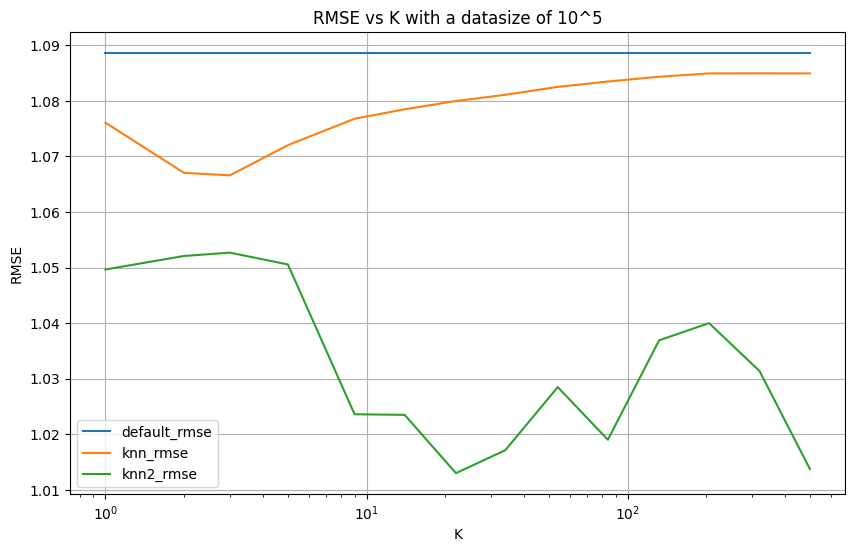

In [ ]:
import matplotlib.pyplot as plt

# Assuming you've already run your previous code and have the df DataFrame
# If you're running this separately, you can load the DataFrame from the CSV:
df = pd.read_csv("rmse_results.csv")

# Plot the data
plt.figure(figsize=(10, 6))

# Plotting each RMSE against K
for column in df.columns:
    if column != "K":
        plt.plot(df["K"], df[column], label=column)

plt.xscale("log")  # Since you used a logspace for K values
plt.xlabel('K')
plt.ylabel('RMSE')
plt.title('RMSE vs K with a datasize of 10^5')
plt.legend()
plt.grid(True)

# Show the plot
plt.show()